In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import pydicom

In [2]:
labels=pd.read_csv("stage_2_train_labels.csv")

In [3]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [4]:
labels=labels.drop_duplicates("patientId")

In [5]:
ROOT_PATH=Path("stage_2_train_images/")
SAVE_PATH=Path("Processed")

In [6]:
from pathlib import Path

ROOT_PATH = Path(r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\stage_2_train_images")
print("Exists?", ROOT_PATH.exists())
print("Number of DICOM files:", len(list(ROOT_PATH.glob("*.dcm"))))


Exists? True
Number of DICOM files: 26684


In [7]:
labels["patientId"].nunique()


26684

In [8]:
import os
len(os.listdir("C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images"))


26684

In [9]:
import glob
glob.glob("C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images/*")[:6]

['C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\000924cf-0f8d-42bd-9158-1af53881a557.dcm',
 'C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\000db696-cf54-4385-b10b-6b16fbb3f985.dcm',
 'C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\000fe35a-2649-43d4-b027-e67796d412e0.dcm',
 'C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\001031d9-f904-4a23-b3e5-2c088acd19c6.dcm',
 'C:/Users/milos/Projects/rsna-pneumonia-detection-challenge/stage_2_train_images\\0010f549-b242-4e94-87a8-57d79de215fc.dcm']

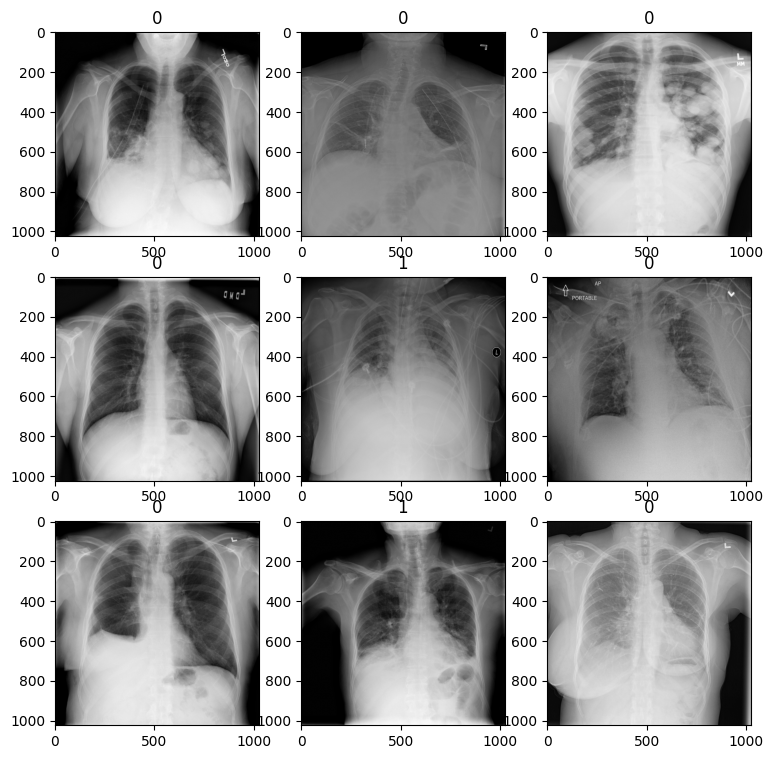

In [10]:
fig,axis=plt.subplots(3,3,figsize=(9,9))
c=0
for i in range(3):
    for j in range(3):
        patient_id=labels.patientId.iloc[c]
        dcm_path=ROOT_PATH/patient_id
        dcm_path=dcm_path.with_suffix(".dcm")
        dcm=pydicom.dcmread(dcm_path).pixel_array

        label=labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="gray")
        axis[i][j].set_title(label)
        c+=1

In [12]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  
    dcm_path = dcm_path.with_suffix(".dcm")  
    

    dcm = pydicom.dcmread(dcm_path).pixel_array / 255  
        
    
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
   
    label = labels.Target.iloc[c]
    
   
    train_or_val = "train" if c < 24000 else "val" 
        
    current_save_path = SAVE_PATH/train_or_val/str(label) 
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  
    if train_or_val == "train": 
        sums += np.sum(dcm_array) / normalizer
        sums_squared +=(dcm_array**2).sum() / normalizer



100%|██████████| 26684/26684 [07:22<00:00, 60.30it/s]


In [13]:
mean=sums/24000
std=np.sqrt((sums_squared/24000)-mean**2)